## 1. Project Definition

### 1.1 Project Overview

The **IBM Global Chief Data Office (GCDO)** is a world-wide team of highly skilled engineers, who develop and maintain the key initiatives that drive IBM's Data and AI transformation.
In the GCDO, we have the **Cognitive Enterprise Data Platform (CEDP)** that serves as the backbone for data and AI processes across the IBM enterprise. Previously siloed data, converges onto one platform and provides a reliable data source.

CEDP offerings consist of various tools and frameworks. It has a dedicated support team to address concerns/issues on all of its offerings. CEDP Support team uses Jira for issue/ticket tracking and resolution.

### 1.2 Problem Statement

In this project, I've analyzed the support tickets data for a period of 30 months since the initiation of the project. Below are a few questions we were interested in exploring:

1. Average resolution time for a ticket. How has it progressed over time? How is the distribution?
2. Busiest hours of the day, week. Monthy patterns among tickets raised 
3. Correlation of the resolution time with other factors.
4. Prediction of ticket labels from the ticket summary. 

Tasks 1,2 & 3 were accomplished by leveraging pandas inbuilt library functionalities. In order to solve the final task of prediction, we used MultiOutput Classification algorithms. Given a processed input summary vector, the model predicted a one-hot encoded vector spanning all possible labels. Since the labels aren't mutually exclusive, a single binary classification model cannot be used.

### 1.3 Metrics used for Evaluation

Since this is a multi-label multi-classification problem, we measure the precision, recall & f-score for each category label. We print the classification report summarising these three parameters for each label, on the test data. 

Since the data for different classes is imbalanced, we used micro-average f1 score for the purpose of evaluation

**Note:**

To test the trained model, please execute the last 3 cells in the notebook.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.stem.porter import PorterStemmer

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.externals import joblib

import re
nltk.download(['punkt'])

[nltk_data] Downloading package punkt to /usr/local/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 2. Analysis 


### 2.1 Data Exploration 

In [2]:
df = pd.read_csv('./jira.csv', index_col='id', dtype={'summary': str})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 4545 to 26315
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   assignee_email  10 non-null     object
 1   assignee_key    10 non-null     object
 2   assigne_name    10 non-null     object
 3   comments_count  10 non-null     int64 
 4   components      10 non-null     object
 5   created         10 non-null     object
 6   creator_email   10 non-null     object
 7   creator_key     10 non-null     object
 8   creator_name    10 non-null     object
 9   issue_type      10 non-null     int64 
 10  labels          10 non-null     object
 11  reporter_email  10 non-null     object
 12  reporter_key    10 non-null     object
 13  reporter_name   10 non-null     object
 14  resolutiondate  10 non-null     object
 15  summary         10 non-null     object
 16  key             10 non-null     object
dtypes: int64(2), object(15)
memory usage: 1.4+ KB


In [3]:
# drop all columns containing PI data, and other unnecessary data
df = df.drop(columns=['assignee_email', 'assignee_key', 'assigne_name', 'creator_email', \
                   'creator_key', 'creator_name', 'reporter_email', 'reporter_key', 'reporter_name'])

In [4]:
print("number of records in the dataset - {}".format(len(df)))
print("number of cells with missing values - {}".format(df.isna().sum().sum()))
print("number of rows with missing data in at least one column - {}".format(df.shape[0] - df.dropna().shape[0]))

number of records in the dataset - 16712
number of cells with missing values - 639
number of rows with missing data in at least one column - 538


In [5]:
df.comments_count.describe()

count    16712.000000
mean         8.778423
std          6.886752
min          0.000000
25%          5.000000
50%          7.000000
75%         11.000000
max        113.000000
Name: comments_count, dtype: float64

Though the mean value for the number of comments on each ticket is 9, we see that 50% of them get closed with <= 7 comments. We could try to take a look at the distribuiton too.

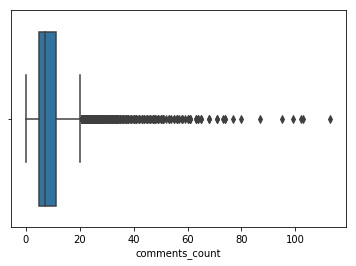

In [6]:
sns.boxplot(df.comments_count)

In [7]:
len(df[df.comments_count > 20])*100/len(df), len(df[df.comments_count > 60])*100/len(df)

(5.3973192915270465, 0.14959310674964096)

A Majority of the tickets get closed with <= 20 comments. About 5% of the tickets have comments_count > 20 and 0.15% of them have comments_count > 60. 

### 2.2 Data Visualisation 

Plot of column index vs missing values in that column, this will give us an estimate of the amount of missing data in the dataset. Based on that we can either remove the missing data, or if its of considerable percent, then we could think of using imputation methods

[0.0, 3.1594064145524174, 0.0, 0.0, 0.6641933939684059, 0.0, 0.0, 0.0]

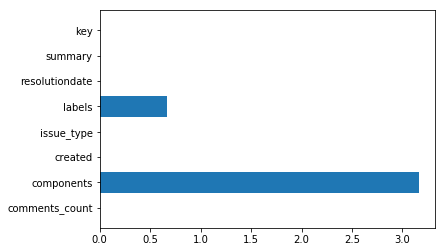

In [8]:
def plot_features_vs_nans(df):
    count = []
    for col in df.columns:
        nan_count = eval("df." + col + ".isna().sum()")
        count.append((nan_count*100)/len(df))
    plt.barh(df.columns, count)
    return count

plot_features_vs_nans(df)

In [9]:
# since the fraction of cells in each col with missing data is very less, we can drop all rows with nan in any col
# drop all rows containing nan/null values 
df = df.dropna()
len(df)

16174

In [10]:
df.head()

,comments_count,components,created,issue_type,labels,resolutiondate,summary,key
id,,,,,,,,
4545,14,1408:,2018-05-11T09:46:53.000+0300,1100,Other_CEDP:,2018-05-18T09:30:34.000+0300,Re-create schemas on <conf> DB2 Warehouse,CSC-14
4547,8,1414:,2018-05-11T10:39:07.000+0300,1203,On-Boarding:,2018-05-14T21:08:32.000+0300,I am an API developer and I need access to blu...,SD-183
4556,10,1406:,2018-05-11T13:44:02.000+0300,1202,DashDB:,2018-05-11T22:56:44.000+0300,connection problem,SD-183
4557,4,1414:,2018-05-11T13:46:45.000+0300,1203,On-Boarding:,2018-05-14T15:11:27.000+0300,I am an API developer and I need access to blu...,SD-183
4583,5,1414:,2018-05-11T15:01:58.000+0300,1203,On-Boarding:,2018-05-11T16:29:05.000+0300,Request for access to <conf> in Artifactory,SD-183


## 3. Task - 1

**Patterns during day, week, months** 


## 3.1 Methodology

### 3.1.1 Data Preprocessing 

The cell value in the labels column are compound values separated by ':' delimiter. We will have to process these labels, and have one column correspoding to each possbile label. The values in those columns will take one-hot encoding, that is, 1 if the label was previous present in the compound label, else 0.  

In [11]:
def get_all_labels(df, col_name, delimiter):
    """
    Returns all possbile fields in a dataframe's column. by spilitting each cell value using the specified delimiter. 
    
    INPUTS:
    df  - pandas dataframe 
    col_name  - column having compound values separated by a delimiter 
    delimiter - character that seperates the values in a cell
    
    OUTPUTS:
    A list of all possible simple values occuring in the column.
    """
    all_labels = set()
    for comp_label in df[col_name]:
        labels = comp_label.split(delimiter)
        for label in labels:
            if label != '':
                all_labels.add(label.lower())
    return list(all_labels)

def one_hot_enc_for_label(cell_value, label):
    """
    Returns binary value based on whether the cell value contains the input label.
    
    INPUTS:
    cell_value - pandas dataframe cell value
    label  = label of onterest
    
    OUTOUTS:
    A binary value 0/1.
    """
    labels = cell_value.lower().split(':')
    if label in labels:
        return 1
    return 0

In [12]:
# get all possible labels 
all_labels = get_all_labels(df, 'labels', ':')

# one hot encoding for each label
for label in all_labels:
    df['label_' + label] = df.labels.apply(lambda x: one_hot_enc_for_label(x, label))
df = df.drop(columns=['labels'])
df = df.dropna()

In [13]:
df.head()

,comments_count,components,created,issue_type,resolutiondate,summary,key,label_other_cedp,label_watson_studio,label_access,label_jiraaccess,label_dashdb,label_data_asset_manager,label_on-boarding
id,,,,,,,,,,,,,,
4545,14,1408:,2018-05-11T09:46:53.000+0300,1100,2018-05-18T09:30:34.000+0300,Re-create schemas on <conf> DB2 Warehouse,CSC-14,1,0,0,0,0,0,0
4547,8,1414:,2018-05-11T10:39:07.000+0300,1203,2018-05-14T21:08:32.000+0300,I am an API developer and I need access to blu...,SD-183,0,0,0,0,0,0,1
4556,10,1406:,2018-05-11T13:44:02.000+0300,1202,2018-05-11T22:56:44.000+0300,connection problem,SD-183,0,0,0,0,1,0,0
4557,4,1414:,2018-05-11T13:46:45.000+0300,1203,2018-05-14T15:11:27.000+0300,I am an API developer and I need access to blu...,SD-183,0,0,0,0,0,0,1
4583,5,1414:,2018-05-11T15:01:58.000+0300,1203,2018-05-11T16:29:05.000+0300,Request for access to <conf> in Artifactory,SD-183,0,0,0,0,0,0,1


In [14]:
# two list of column names, one for labels and the other for non-labels 
non_label_cols = ['components', 'created', 'issue_type', 'resolutiondate', 'summary', 'key', 'comments_count']
label_cols = list(set(df.columns).difference(set(non_label_cols)))

In [15]:
len(non_label_cols), len(label_cols)

(7, 89)

In [16]:
def plot_data(title, xlabel, ylabel, series, xticks, fmt, figsize=(14, 5), linestyle=':'):
    """
    Plots a line graph with the pandas series's index on x-axis and value on y-axis.
    
    INPUTS:
    title  - title for the plot
    xlabel - label for the x-axis
    ylabel - label for the y-axis
    series - pandas series 
    xticks - label for each tick on the x-axis 
    fmt - format string, which is eventually passed in to plot
    figsize - size of the plot  
    linestyle - linestyle char, which is eventually passed in to plot
    """
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(np.arange(0, len(series.index), 1), series, fmt, linestyle=':')
    ax.set_xticks(np.arange(0, len(series), 1))
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=14)
    ax.set_xticklabels(xticks, rotation='30', fontsize=10, ha='right')
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    plt.show()

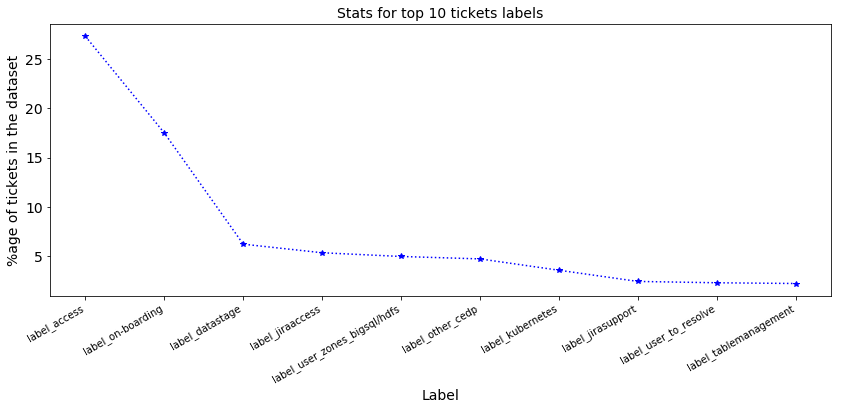

In [17]:
s = pd.Series(df[label_cols].sum().sort_values(ascending=False)*100/len(df))
plot_data('Stats for top 10 tickets labels', 'Label', \
          '%age of tickets in the dataset', s[:10], s.index[:10], 'b*')

### 3.1.2 Implementation 
**Weekly, Monthly patterns**
1. Which is the busiest hour during the day, when most of the tickets are rasied?
2. Which is the busiest day during the week?
3. How does the monthly tickets volume look?

In [18]:
# create a sub dataframe holding only the necessary columns, one-hot enc of all labels, ticket summary, creation 
# and resolution date.
sub_df = df.loc[:, label_cols]

# ignore the seconds and timezone info
sub_df['created'] = df['created'].apply(lambda x: pd.Timestamp(x[:-9]))
sub_df['resolutiondate'] = df['resolutiondate'].apply(lambda x: pd.Timestamp(x[:-9]))
sub_df['summary'] = df['summary']

# drop all rows having null/nan values 
sub_df = sub_df.dropna()

In [19]:
def get_hour_day_month(sub_df, prefix, col):
    """
    Appends columns to the dataframe, contaning information on hour, day, moth, year of the values in column 'col'
    
    INPUTS:
    sub_df - pandas dataframe 
    prefix - prefix character for the new columns being added 
    col    - the column in the dataframe containing pandas timestamp
    
    OUTPUTS:
    The input dataframe, with four coulmns added.
    """
    sub_df[prefix + 'hour'] = sub_df[col].apply(lambda x: int(x.hour))
    sub_df[prefix + 'day'] = sub_df[col].apply(lambda x: int(x.dayofweek))
    sub_df[prefix + 'month'] = sub_df[col].apply(lambda x: int(x.month))
    sub_df[prefix + 'year'] = sub_df[col].apply(lambda x: int(x.year))
    return sub_df

sub_df = get_hour_day_month(sub_df, 'c_', 'created')
sub_df = get_hour_day_month(sub_df, 'r_', 'resolutiondate')
# consider data from 2018 to July 2020
sub_df = sub_df[((sub_df.c_year >= 2018) & (sub_df.c_year < 2020)) | ((sub_df.c_year == 2020) & (sub_df.c_month < 8))]

## 3.2 Results 
### 3.2.1 Visualisations & 3.2.2 Insights/Justifications

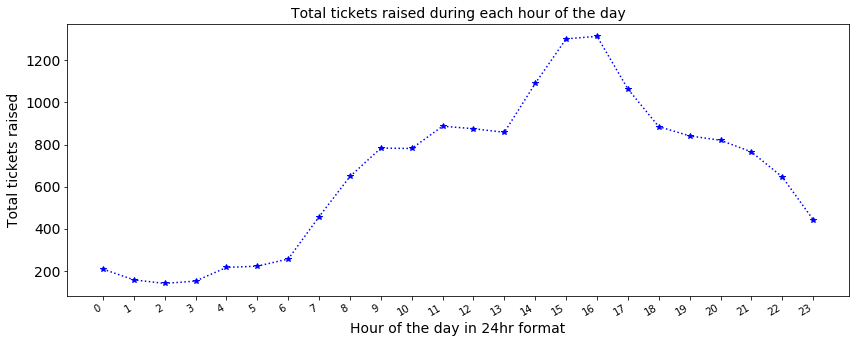

In [20]:
s = pd.Series(sub_df.groupby('c_hour').size())
plot_data('Total tickets raised during each hour of the day', 'Hour of the day in 24hr format', \
          'Total tickets raised', s, s.index, 'b*')

The busiest hours in the day seem to be around 14 –17 GMT. The period with considerably low activity seems to be around 00–06 GMT.

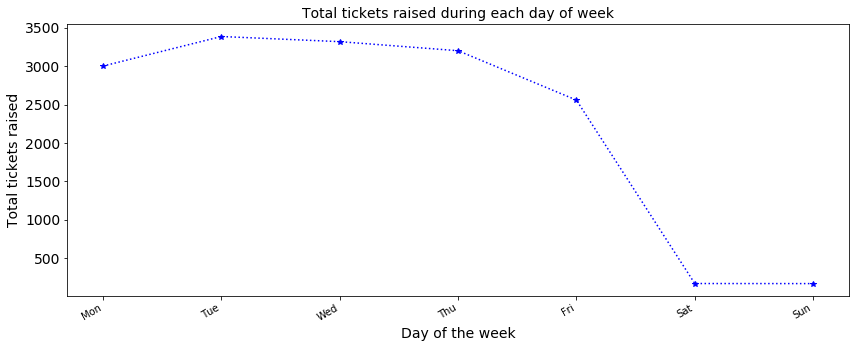

In [21]:
weekdays = np.array(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
s = pd.Series(sub_df.groupby('c_day').size())
plot_data('Total tickets raised during each day of week', 'Day of the week', \
          'Total tickets raised', s, weekdays, 'b*')

All weekdays seem to show similar behaviour, with exclusion of Friday. Weekends display too low activity in comparision to weekdays.

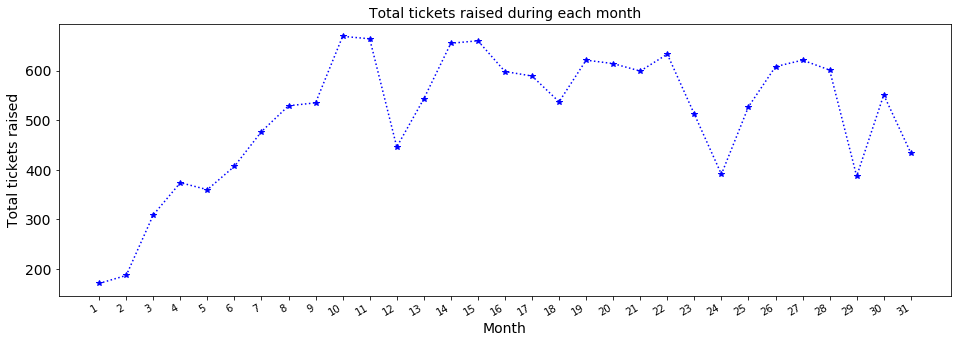

In [22]:
s = pd.Series(sub_df.groupby(['c_year', 'c_month']).size())
plot_data('Total tickets raised during each month', 'Month', 'Total tickets raised', s, \
          np.arange(1, len(s.index) + 1, 1), 'b*', (16, 5))

If we ignore data points before Month 8 (since the project was in the starting phase), the ticket activity seems to be low during months (12,24) & (17-18, 29). The pattern is repetitive every year, this might be due to a larger portion of employees being on vacation. 

## 4. Task - 2
**Insights on Ticket resoltuion time**
1. What is the average ticket resolution time? Is there any significant reduction as time progressed?

2. Box plots for ticket resolution time. Any outliers? Which categories do these tickets belong to?

3. Is there any correlation between resoltion time and ticket creation day/hour?

## 4.1 Methodology 

### 4.1.1 Data Preprocessing & 4.1.2 Implementation

In [23]:
# calculate the time tqaken for resolution in hours
sub_df['rt_hours'] = (sub_df['resolutiondate'] - sub_df['created']).astype('timedelta64[h]')

## 4.2 Results 

### 4.2.1 Visualisation & 4.2.2 Insights/Justifications 

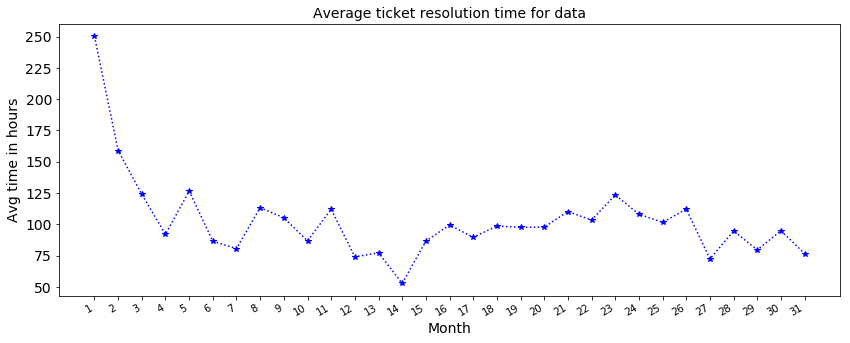

In [24]:
s = sub_df[['c_year', 'c_month', 'rt_hours']].groupby(['c_year', 'c_month']).mean()
plot_data('Average ticket resolution time for data', 'Month', 'Avg time in hours', s, \
          np.arange(1, len(s.index) + 1, 1), 'b*')

Here too, from Month 8 the average resolution time  has been somewhat steady. 

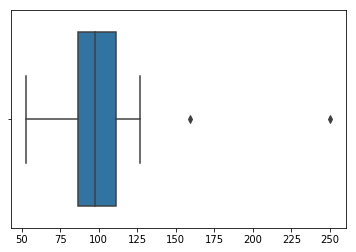

In [25]:
# A boxplot ofthe resolution times for the support tickets 
sns.boxplot(s)

In [26]:
# Tickets belonging to which categories take more time 
s = pd.Series(sub_df[label_cols][sub_df.rt_hours > 225].sum()).sort_values(ascending=False)[:10]
s

label_access                    518
label_on-boarding               237
label_other_cedp                 91
label_datastage                  68
label_tablemanagement            64
label_infrastructure             54
label_user_to_resolve            50
label_jirasupport                49
label_user_zones_bigsql/hdfs     45
label_kubernetes                 43
dtype: int64

The top 10 categories of tickets that could take more time to be resolved.

In [27]:
# calculate correlation of rt_hours with each column, and print the top positive and negative factors
cor_vals = []
for col in sub_df.columns:
    if col not in ['created', 'resolutiondate', 'summary', 'rt_hours']:
        val = sub_df.rt_hours.corr(sub_df[col])
        if col == 'c_day':
            print('Correlation of r_time with c_day: {:.2f}'.format(val))
        if not np.isnan(val):
            cor_vals.append((val, col))
cor_vals.sort(key=lambda x: x[0], reverse=True)

print("\n")
[print(cor_vals[i]) for i in range(10)]
print("\n")
[print(cor_vals[i]) for i in range(len(cor_vals) - 10, len(cor_vals), 1)]
print("\n")

Correlation of r_time with c_day: 0.04


(0.3649367549705909, 'label_communications')
(0.16976031413658885, 'label_slack')
(0.13434014394960317, 'label_drop_zone_hdfs')
(0.044055466735704214, 'c_day')
(0.0422236307390891, 'label_dsx')
(0.037569559034112646, 'r_year')
(0.03617349541575629, 'label_cedp_portal')
(0.027266390108638926, 'label_infrastructure')
(0.024869122100125627, 'label_kafka')
(0.02462988890088302, 'label_tablemanagement')


(-0.0102766878540633, 'label_db2w')
(-0.012732874627784215, 'r_hour')
(-0.014956131865238724, 'label_onboarding')
(-0.016658370423005466, 'c_year')
(-0.01736001509937245, 'r_day')
(-0.020273837162341247, 'label_user_zones_bigsql/hdfs')
(-0.021042992890451525, 'label_datastage')
(-0.027820149322532853, 'label_on-boarding')
(-0.03373602031540195, 'label_github_access')
(-0.05026621456531853, 'label_jiraaccess')




label_communications signifies error while connecting to the SQL engine, the higher correlation values suggests that issues of these type typically take more time to be resolved. 

Correlation with c_day is 0.04, indicating that there is no much difference in resolution as the weekend approaches. 

## 5. Task - 3

**Prediction of ticket labels from ticket summary**

## 5.1 Methodology

### 5.1.1 Data Preprocessing 

Given the ticket summary as input, predict the labels for the ticket 

In [28]:
# A few labels actually convey the same things. We need to group the labels accordingly. Below is a map, 
# with key as one of the labels, and value being a list of all similar labels. Also the keys are the only 
# labels we are interested in predicting currently. 
helper_map = {
  'access_control': ['accessissue', 'on-boarding', 'off-boarding', 'access'],
  'db2': ['db2w', 'db2woc', 'db2whocaccess', 'db2wocaccess', 'dashdb', 'db2whoc', 'infrastructure'],
  'datastage': ['iis_tools', 'catalog'],
  'dsx': ['watson_studio', 'cloud', 'publiccloud'],
  'drop_zone': ['drop_zone_hdfs'],
  'bigsql': ['lz','landingzone', 'user_zones_bigsql/hdfs'],
  'jiraaccess': ['jira_access', 'jirasupport', 'jira'],
  'kubernetes': ['icp'],
  'documentation': ['cedp_portal'], 
  'non_cedp': ['other_cedp', 'non_support'],
  'elasticsearch': ['esa']
}

# set the column value based on OR of all similar columns. Append the col name into 'labels_interested', if and 
# only if the number of samples are > 100
labels_interested = []
for key, val in helper_map.items():
    for v in val:
        sub_df['label_' + key] = sub_df['label_' + key] | sub_df['label_' + v]
    sum_ = sub_df['label_' + key].sum()
    print('Samples for label {}: {}'.format(key, sum_))
    if sum_ > 100:
        labels_interested.append('label_' + key)

Samples for label access_control: 7127
Samples for label db2: 998
Samples for label datastage: 1021
Samples for label dsx: 462
Samples for label drop_zone: 141
Samples for label bigsql: 829
Samples for label jiraaccess: 1483
Samples for label kubernetes: 577
Samples for label documentation: 10
Samples for label non_cedp: 929
Samples for label elasticsearch: 59


### 5.1.2 Implementation

We train a multi-class multi-label Classification pipeline using Random Forest Classifier and Grid Search to find the best parameters. The input text is tokenized using commonly used techniques such as CountVectorizer and tf-idf transformation. Latent Semantic Analysis is performed on this for dimensionality reduction. 

In [29]:
def load_data(df, category_names):
    """
    Returns the train input & outout data, given the pandas dataframe.
    
    INPUTS:
    df - pandas dataframe 
    category_names - list of label columns, that we are interested in predicting 
    
    RETURNS:
    training data, both model inout and the output that has to be fed. 
    """
    X = df['summary']
    Y = df[category_names]
    return X, Y

def tokenize(text):
    """
    Function to tokenize input text.
    """
    text = word_tokenize(re.sub(r'[^a-zA-Z0-9]', ' ', text))
    stem = PorterStemmer()
    return [stem.stem(word.lower().strip()) for word in text]

def build_model():
    """
    Returns a pipeline for multi-class classification of text input
    """
    pipeline = Pipeline([ \
        ('vect', CountVectorizer(tokenizer=tokenize)), \
        ('tfidf', TfidfTransformer()), \
        ('svd', TruncatedSVD(n_components=50, random_state=42)), \
        ('clf', MultiOutputClassifier(RandomForestClassifier(n_estimators=50, random_state=42))) \
    ])
    return pipeline

def evaluate_model(model, X_test, y_test, category_names):
    """
    Prints classification report for test data on each category
    """
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    return 

In [30]:
category_names = labels_interested
X, Y = load_data(sub_df, category_names)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=23)

len(X_train), len(Y_train), len(X_test), len(Y_test)

(12647, 12647, 3162, 3162)

In [31]:
model = build_model()
model.fit(X_train, Y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...           oob_score=False, random_state=42, verbose=0, warm_start=False),
           n_jobs=None))])

In [32]:
evaluate_model(model, X_test, Y_test, category_names)

              precision    recall  f1-score   support

           0       0.81      0.74      0.77      1402
           1       0.80      0.17      0.28       220
           2       0.74      0.38      0.50       201
           3       0.75      0.18      0.29        84
           4       0.20      0.04      0.06        28
           5       0.80      0.22      0.35       199
           6       0.71      0.44      0.54       268
           7       0.94      0.22      0.35       133
           8       0.47      0.04      0.08       191

   micro avg       0.79      0.50      0.61      2726
   macro avg       0.69      0.27      0.36      2726
weighted avg       0.77      0.50      0.57      2726
 samples avg       0.43      0.43      0.43      2726



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


### 5.1.3 Refinement 

Do a grid search to find the best parameters for the model. 

In [33]:
def build_model_with_grid_search():
    """
    Returns a grid search pipeline for multi-class classification of text input
    """
    pipeline = Pipeline([ \
        ('vect', CountVectorizer(tokenizer=tokenize)), \
        ('tfidf', TfidfTransformer()), \
        ('svd', TruncatedSVD(random_state=42)), \
        ('clf', MultiOutputClassifier(RandomForestClassifier(random_state=42))) \
    ])
    parameters = { \
        'svd__n_components': [20, 50], \
        'clf__estimator__min_samples_split': [2, 4], \
        'clf__estimator__min_samples_leaf': [1, 2], \
        'clf__estimator__n_estimators': [50, 100] \
    }
    cv = GridSearchCV(pipeline, parameters, cv=3)
    return cv

In [34]:
model_gs = build_model_with_grid_search()
model_gs.fit(X_train, Y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...           oob_score=False, random_state=42, verbose=0, warm_start=False),
           n_jobs=None))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'svd__n_components': [20, 50], 'clf__estimator__min_samples_split': [2, 4], 'clf__estimator__min_samples_leaf': [1, 2], 'clf__estimator__n_estimators': [50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [35]:
model_gs.best_params_

{'clf__estimator__min_samples_leaf': 1,
 'clf__estimator__min_samples_split': 2,
 'clf__estimator__n_estimators': 100,
 'svd__n_components': 50}

## 5.2 Results 

### 5.2.1 Model Evaluation 

In [36]:
evaluate_model(model_gs, X_test, Y_test, category_names)

              precision    recall  f1-score   support

           0       0.81      0.74      0.78      1402
           1       0.82      0.19      0.31       220
           2       0.75      0.38      0.51       201
           3       0.74      0.20      0.32        84
           4       0.33      0.04      0.06        28
           5       0.76      0.22      0.34       199
           6       0.71      0.44      0.55       268
           7       0.93      0.20      0.32       133
           8       0.50      0.04      0.08       191

   micro avg       0.80      0.50      0.62      2726
   macro avg       0.71      0.27      0.36      2726
weighted avg       0.77      0.50      0.57      2726
 samples avg       0.43      0.44      0.43      2726



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


### 5.2.2 Justification

Grid Search tends to outperform the base model by a slight margin. This is because, grid search internally fits all possible combinations with the input configurations and outputs the best model.

In [38]:
# save the model
joblib.dump(model_gs, './classifier.pkl', compress=1)

['./classifier.pkl']

**Predict labels from ticket summary, test the built model**

Please execute these 3 cells for testing the saved model.

In [2]:
def tokenize(text):
    """
    Function to tokenize input text.
    """
    text = word_tokenize(re.sub(r'[^a-zA-Z0-9]', ' ', text))
    stem = PorterStemmer()
    return [stem.stem(word.lower().strip()) for word in text]

labels_interested = ['label_access_control', 'label_db2', 'label_datastage', \
'label_dsx', 'label_drop_zone', 'label_bigsql', 'label_jiraaccess', 'label_kubernetes', 'label_non_cedp']

In [3]:
# load the saved model
model = joblib.load("./classifier.pkl")

In [4]:
test_msgs = ['not able to view pod logs on namespace cxyz_dev', \
'cedp iz prod env is very slow', \
'need access to namespace cxyz_dev on icp to view pod logs']

# expected labels 
# not able to view pod logs on namespace cxyz_dev - kubernetes 
# cedp iz prod env is very slow - db2
# need access to namespace cxyz_dev on icp to view pod logs - kubernetes, access
classification_labels = model.predict(test_msgs)
for i in range(len(test_msgs)):
    x = [labels_interested[k] for k in range(len(classification_labels[i])) if classification_labels[i][k] == 1]
    print('{}: {}'.format(test_msgs[i], x))

not able to view pod logs on namespace cxyz_dev: ['label_kubernetes']
cedp iz prod env is very slow: ['label_db2']
need access to namespace cxyz_dev on icp to view pod logs: ['label_access_control']


## 6. Conclusion

**Average resolution time for a ticket. How has it progressed over time? How is the distribution?**

From Month 8, the average resolution time  has been somewhat steady. 


**Busiest hours of the day, week. Monthy patterns among tickets raised**

All weekdays seem to show similar behaviour, with exclusion of Friday. Weekends display too low activity in comparision to weekdays.


**Correlation of the resolution time with all other factors.**

label_communications signifies error while connecting to the SQL engine, the correlation values suggest that issues of these type typically take more time to be resolved. Correlation with c_day is 0.04, indicating that there is no much difference in resolution as the weekend approaches.


**Prediction of ticket labels from the ticket summary.**

The model performs well on predicting single classes, but doesn't seem to perform well in identifying multiple labels. Also, the training data was filtered and only interested labels were taken into consideration (due to lack of sufficient data). 

**Improvement**

For multi-class multi-output classification, if we had enough data across all labels, may the the model would have performed better. We could also have tried using features like word2vec and sent2vec as input features. And since this is a specific domain, we will have to train the word2vec/sent2vec models on this specific corpus and then use them as features. 

Since we are dealing with imbalanced data, we could try out models that are know to perform better in such cases, like GradientBoostingClassifier

We could try other ensemble techniques like AdaBoostClassifier

We could also look at building a custom ensemble model with multiple supervised learning classifiers